In [11]:
# Standard library imports
import os
import re
import io 
import pickle
import math
import multiprocessing
import itertools as it
import ipywidgets as widgets
from IPython.display import display
import random

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


# Third-party imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from pyDOE import lhs
from ipywidgets import interact, interact_manual, interactive
from IPython.display import HTML
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



# Project-specific imports
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Agents.StrategySARSA import stratSARSA
from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Utils import FlowPlot as fp

# Set matplotlib style and parameters
style.use('seaborn-v0_8')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.facecolor': 'white',
    'grid.color': 'gray',
    'grid.linewidth': 0.0,
    'figure.dpi': 140,
    'axes.prop_cycle': plt.cycler(color=['#1f77b4'])  # Example to set the first color
})

# Use interactive widgets for dynamic behavior in Jupyter notebooks
interact = interact_manual if 'get_ipython' in locals() else interact
# Warnings
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, module='pandas.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn.*')


# In this notebook we aim to visualize and analysis the outputs of the models.

In [12]:

uploader = widgets.FileUpload(
    accept='.pkl',  # Accept only .pkl files
    multiple=True  # Allow multiple files to be uploaded
)
display(uploader)

def load_and_store_files():
    datasets = {}
    # Process each item in the tuple 
    for file_info in uploader.value:
        filename = file_info['name']
        content = io.BytesIO(file_info['content'])
        data = pickle.load(content)  # Load the pickle file content
        datasets[filename] = data  # Store data in dictionary with filename as key
    return datasets

def extract_info(filename):
    # Dictionary to store the extracted information
    info_dict = {}
    
    # Regular expression to match parts of the filename
    pattern = r'\((.*?)\)(.*?)_for_(.*?)_projection_(\d+)_init_points=(\d+)_n_iter=(\d+)\.pkl'
    match = re.match(pattern, filename)
    
    if match:
        info_dict['method'] = match.group(1)  # Bayesian
        info_dict['model'] = match.group(2)  # All_model_fit
        info_dict['agent'] = match.group(3)  # AC_agent
        info_dict['projection'] = int(match.group(4))  # 78
        info_dict['init_points'] = int(match.group(5))  # 10
        info_dict['n_iterations'] = int(match.group(6))  # 4000
    else:
        print("Filename format does not match expected pattern.")
    
    return info_dict

def on_load_button_clicked(b):
    global datasets  
    datasets = load_and_store_files()
    for filename, data in datasets.items():
        info = extract_info(filename)
        print(f"Data from {filename}:")

load_button = widgets.Button(description="Load and Display Data")
load_button.on_click(on_load_button_clicked)
display(load_button)


FileUpload(value=(), accept='.pkl', description='Upload', multiple=True)

Button(description='Load and Display Data', style=ButtonStyle())

Filename format does not match expected pattern.
Data from (Bayesian)RiskReward for Agent AC_init_points=10_n_iter=1000.pkl:


In [14]:

def correlation_error(datasets, cutoff):

    
    for dataset_name, data in datasets.items():
        actual_cutoff = min(cutoff, len(data))
        if actual_cutoff == 0:
            continue  

        # Initialize lists for each parameter and the target
        pc, pr, rs, rr, learning_rate, discount_factor, c ,error= [], [], [], [], [], [], [], []

        for record in data:
            params = record['params']
            pc.append(params.get('pc', 0))
            pr.append(params.get('pr', 0))
            rs.append(params.get('rs', 0))
            rr.append(params.get('rr', 0))
            learning_rate.append(params.get('learning_rate', 0))
            discount_factor.append(params.get('discount_factor', 0))
            c.append(params.get('c', 0))
            error.append(-record.get('target', 0)) 
        # Compile data into a DataFrame
        df = pd.DataFrame({
            "Pc": pc,
            "Pr": pr,
            "Rs": rs,
            "Rr":rr,
            "Learning_rate": learning_rate,
            "Discount_factor":discount_factor,
            "C": c,
            "Error": error
        })

        
        df = df.sort_values(by='Error')
        df_complete = df.copy()
        df['Size'] = df['Error'].apply(lambda x: x)
        df = df.iloc[:actual_cutoff]
        Errors = df_complete["Error"].tolist()
        
                
        # Plotting
        plt.figure(figsize=(12, 6))  
        plt.plot(Errors)  
        plt.axvline(x=cutoff, color='red', linewidth=2, label=f"Cutoff Error={df_complete.iloc[cutoff]['Error']}")

        plt.title(f"Error Distribution for {dataset_name}", fontsize=16)  # Increased font size for title
        plt.xlabel('Index', fontsize=12)
        plt.ylabel('Error Value', fontsize=12)

        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.7)
        plt.yscale('log')

        plt.show()

        
        
        
        g = sns.PairGrid(df.drop(columns=['Size']))
        g.map_upper(sns.scatterplot, size=df['Size'], legend=False)
        g.map_lower(sns.kdeplot, cmap='coolwarm')
        g.map_diag(sns.histplot, kde=True)

        for i in range(len(g.axes)):
            for j in range(len(g.axes)):
                ax = g.axes[i, j]
                if i < j:
                    ax.set_facecolor('lightgrey')  
                elif i == j:
                    ax.set_facecolor('lightyellow')  

        g.fig.subplots_adjust(left=0.1, right=0.99, top=0.99, bottom=0.1, hspace=0.1, wspace=0.1)

        g.fig.suptitle(f"Pair Plot for {dataset_name}", y=1.02, fontsize=16)

        plt.show()

        corr_matrix = df.drop(columns=['Size']).corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title(f"Correlation Matrix for {dataset_name}")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return df





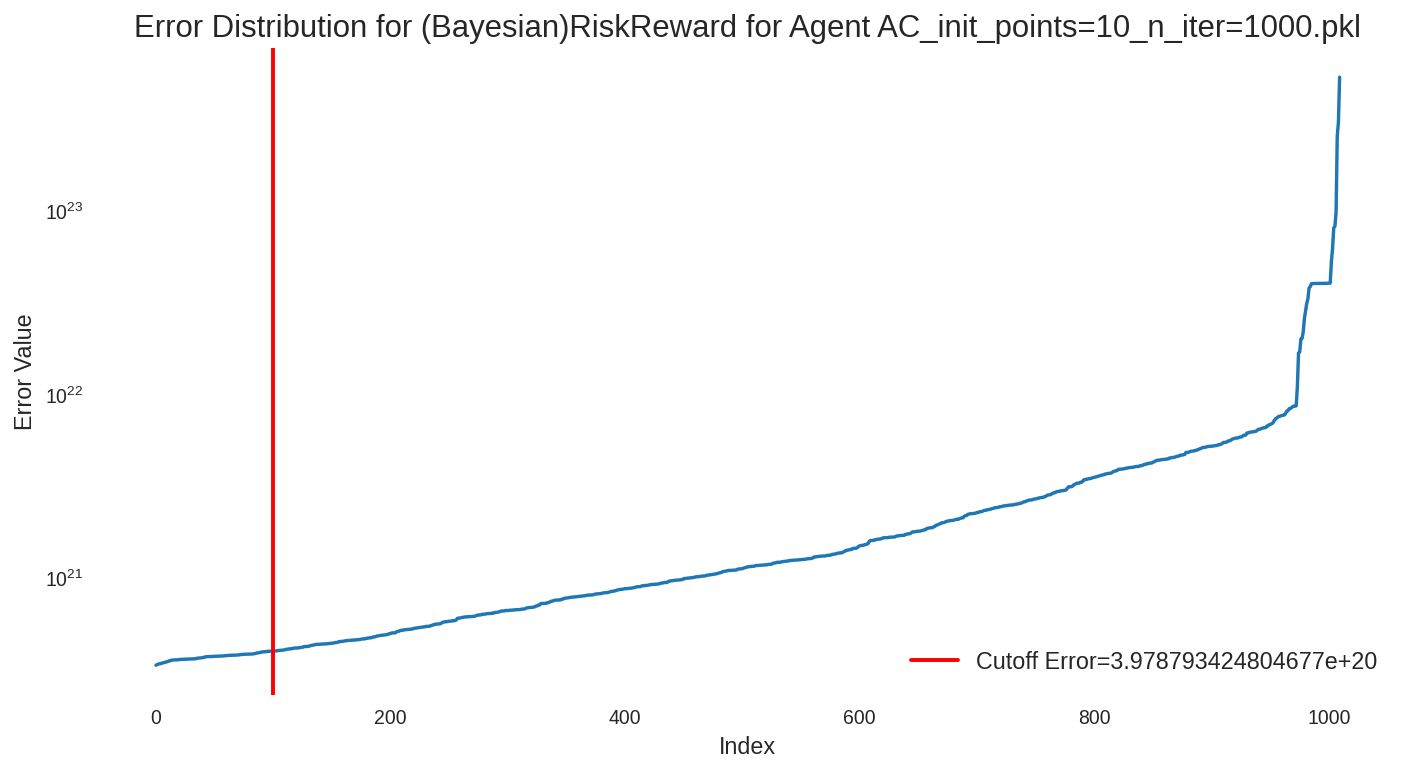

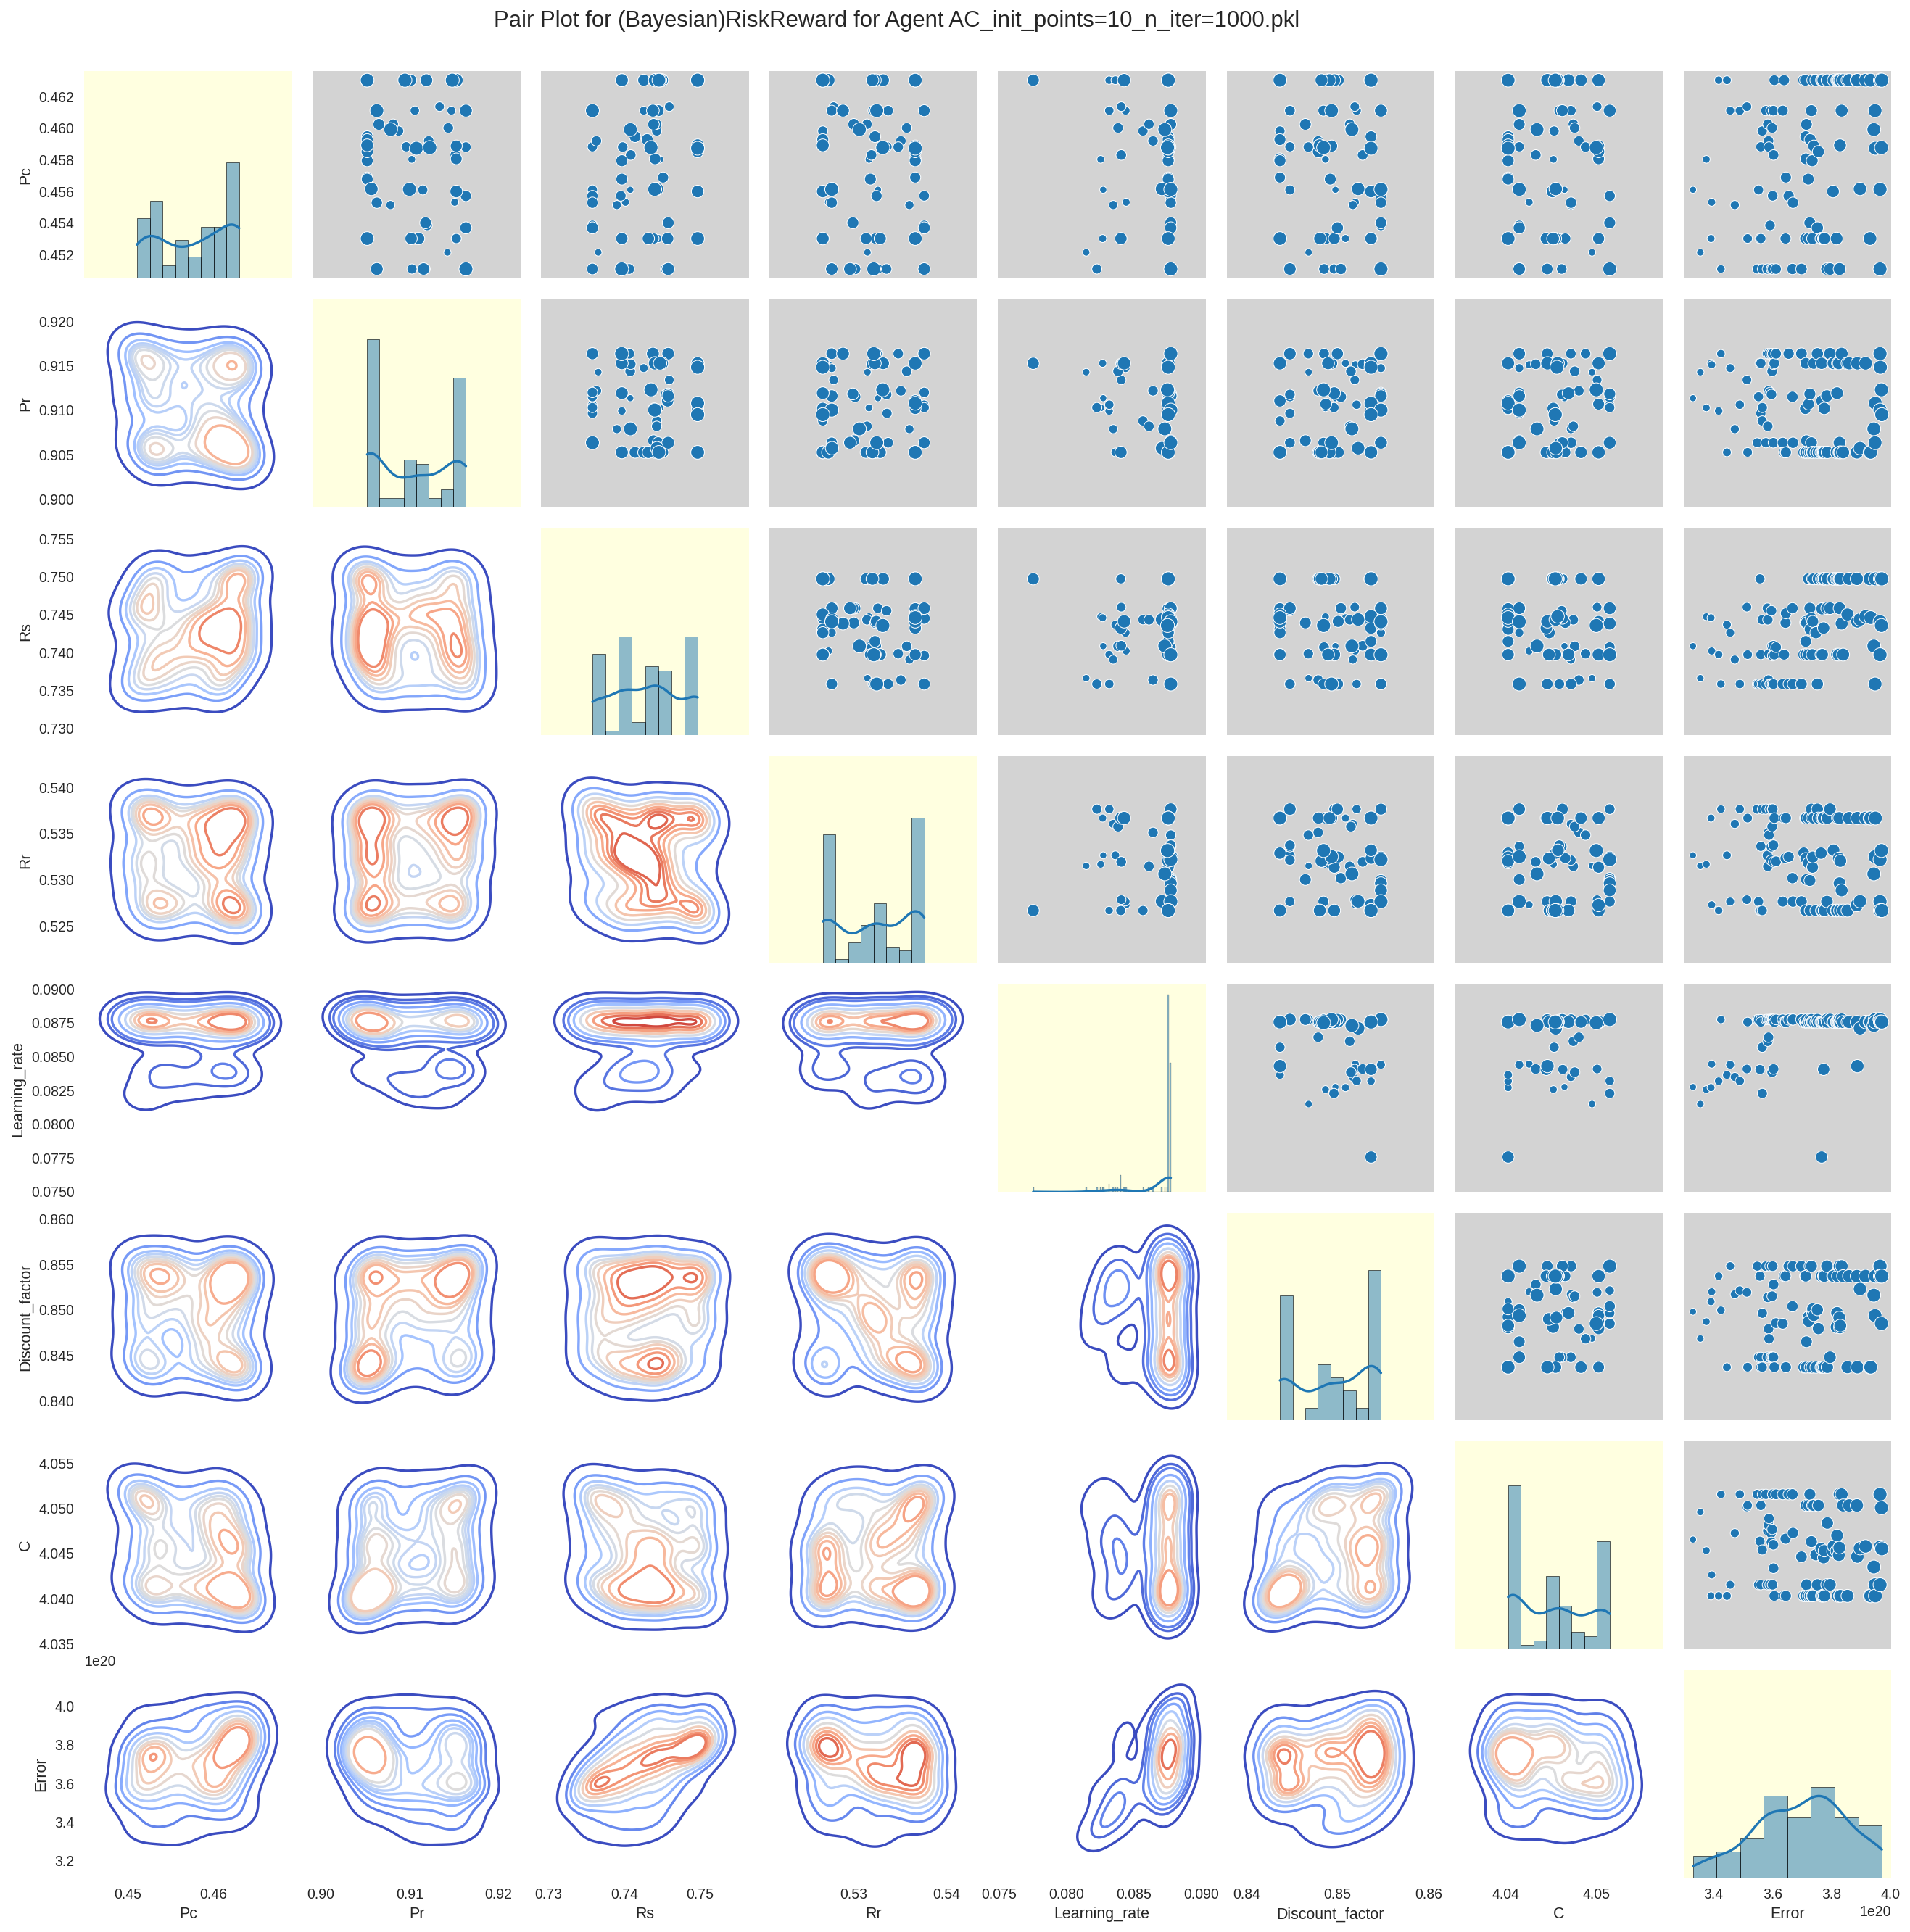

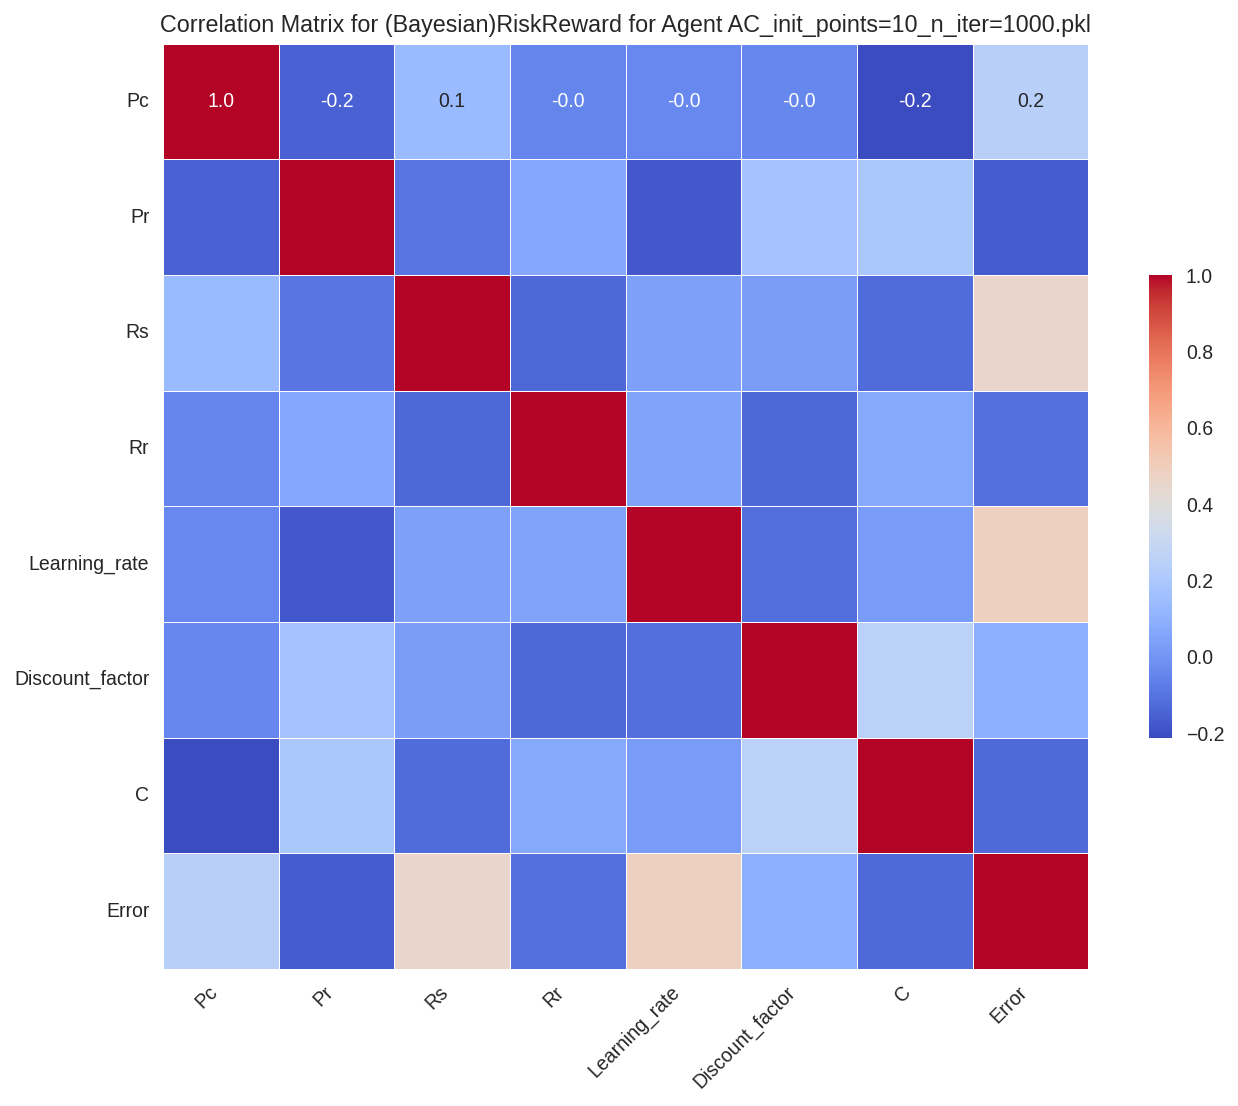

In [15]:
df = correlation_error(datasets, 100)


In [10]:
cutoff = 100
all_files = []
all_files_names = []
for dataset_name, data in datasets.items():
        all_files_names.append(dataset_name)
        actual_cutoff = min(cutoff, len(data))
        if actual_cutoff == 0:
            continue  

        # Initialize lists for each parameter and the target
        fears, temps, Xcs, learning_rates, choice_intensities, discount_factors, cs, errors = [], [], [], [], [], [], [], []

        for record in data:
            params = record['params']
            fears.append(params.get('f', 0))
            temps.append(params.get('t', 0))
            Xcs.append(params.get('Xc', 0))
            learning_rates.append(params.get('learning_rate', 0))
            choice_intensities.append(params.get('choice_intensities', 0))
            discount_factors.append(params.get('discount_factors', 0))
            cs.append(params.get('c', 0))
            errors.append(-record.get('target', 0))  # Using get to avoid KeyError

        # Compile data into a DataFrame
        df = pd.DataFrame({
            "Fear": fears,
            "Temptation": temps,
            "Xc": Xcs,
            "Learning Rate": learning_rates,
            "Choice Intensity": choice_intensities,
            "Discount Factor": discount_factors,
            "C": cs,
            "Error": errors
        })

        
        df = df.sort_values(by='Error')
        df['Size'] = df['Error'].apply(lambda x: x)
        all_files.append(df)

# Polynomial Regression 


## Polynomial Features

**Polynomial Features** extend linear models by including polynomial terms (squared, cubic, etc.) of the original features. This allows the model to capture non-linear relationships between the features and the target variable, which linear models cannot model effectively.

- **Mathematical Representation**: If an original feature set is $[x_1, x_2]$, polynomial features of degree 2 would include $[x_1, x_2, x_1^2, x_1 x_2, x_2^2]$.
- **Purpose**: Enhances the model's capability to capture complex patterns in data, thereby increasing the flexibility of the model without switching to a inherently more complex model.

## Mean Squared Error (MSE)

**Mean Squared Error (MSE)** is a common loss function used to measure the average of the squares of the errors—that is, the average squared difference between the estimated values ($\hat{Y_i}$) and the actual value ($Y_i$).

- **Formula**: 
  $$
  MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y_i})^2
  $$
Provides a measure of how well the model predicts the target variable. Lower MSE values indicate a better fit, suggesting that the model's predictions are close to the actual data.

## Cross-Validation

**Cross-Validation** is a technique for assessing how the results of a statistical analysis will generalize to an independent data set. It is primarily used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

- **K-Fold Cross-Validation**: The data set is divided into $k$ smaller sets or "folds". The model is trained on $k-1$ of these folds, with the remaining part used as a test set to compute a performance measure such as MSE.
- **Purpose**: Reduces overfitting risk and provides a better insight into how the model will perform on unseen data.

## Regression

### Ridge Regression (L2 Regularization)

- **Concept**: Adds a penalty equal to the square of the magnitude of coefficients to the loss function (L2 norm). This approach minimizes complexity by penalizing large coefficients, which helps prevent overfitting.
- **Formula**: 
  $$
  \text{Cost function} = MSE + \lambda \sum_{i=1}^n \beta_i^2
  $$
  where $\lambda$ is the regularization strength.

### Lasso Regression (L1 Regularization)

- **Concept**: Adds a penalty equal to the absolute value of the magnitude of coefficients (L1 norm). Unlike Ridge, Lasso can zero out some coefficients entirely, effectively performing feature selection by eliminating non-influential features.
- **Formula**: 
  $$
  \text{Cost function} = MSE + \lambda \sum_{i=1}^n |\beta_i|
  $$
  This characteristic makes Lasso particularly useful when you suspect that some data features are irrelevant.

## Decision Tree-based Methods

**Random Forest** is an ensemble tree-based learning algorithm.

- **Feature Importances**: Measures how each feature contributes to the accuracy of the model by observing the decrease in node impurity across all trees in the forest. This measure is particularly useful for understanding which features are most important in predicting the target variable.
- **Non-linear Capability**: Can capture complex interaction between features that linear models may miss, making it suitable for data with intricate patterns.



# Investigation of C

In [ ]:

# Models configuration

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(max_iter=50000),  
    'Lasso Regression': Lasso(alpha=0.01, max_iter=50000),  
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

# Results processing for each file
for i, df in enumerate(all_files):
    # Preprocess data
    df = df.iloc[:100].copy()
    df.loc[:, 'Error'] = df['Error'].apply(lambda x: x / 10e10)
    df.loc[:, 'C'] = df['C'].apply(lambda x: x / 10e10)

    features = df[['Fear', 'Temptation', 'Xc', 'Learning Rate', 'Choice Intensity',"Error"]]
    target = df['C']

    # Prepare to store the best model information
    best_model_info = {'name': None, 'degree': None, 'mse': float('inf')}

    # Setup cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate each model at various degrees of polynomial features
    for model_name, model in models.items():
        avg_scores = []
        degrees = list(range(1, 4))  # max_degree set to 3

        for degree in degrees:
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            features_poly = poly.fit_transform(features)
            scores = cross_val_score(model, features_poly, target, cv=kf, scoring='neg_mean_squared_error')
            avg_scores.append(np.mean(scores))

        # Identify the best degree based on MSE
        mse_scores = [-score for score in avg_scores]
        best_degree = degrees[np.argmin(mse_scores)]

        if np.min(mse_scores) < best_model_info['mse']:
            best_model_info.update({'name': model_name, 'degree': best_degree, 'mse': np.min(mse_scores)})

        # Plot MSE vs. Degree
        plt.figure(figsize=(8, 4))
        plt.plot(degrees, mse_scores, marker='o')
        plt.title(f'MSE by Polynomial Degree for {model_name} - {all_files_names[i]}')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('Mean Squared Error')
        plt.grid(True)
        plt.show()

    # Fit the best model with the optimal polynomial degree
    poly = PolynomialFeatures(degree=best_model_info['degree'], include_bias=False)
    features_poly = poly.fit_transform(features)
    best_model = models[best_model_info['name']].fit(features_poly, target)

    # Visualize the coefficients or feature importances
    if hasattr(best_model, 'coef_'):
        coefficients = best_model.coef_
        feature_names = poly.get_feature_names_out(features.columns)
        metric_name = 'Coefficient'
    elif hasattr(best_model, 'feature_importances_'):
        coefficients = best_model.feature_importances_
        feature_names = poly.get_feature_names_out(features.columns)
        metric_name = 'Importance'
    
    coef_df = pd.DataFrame({'Feature': feature_names, metric_name: coefficients})
    coef_df['Abs_Metric'] = np.abs(coef_df[metric_name])
    coef_df_sorted = coef_df.sort_values(by='Abs_Metric', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Abs_Metric', y='Feature', data=coef_df_sorted.head(20))
    plt.title(f"Top Features at Degree {best_model_info['degree']} for {best_model_info['name']}: {all_files_names[i]} Target:C")
    plt.show()

    print(f"Best Model: {best_model_info['name']} with Degree: {best_model_info['degree']} and MSE: {best_model_info['mse']}")


# Investigation of Errors

In [ ]:

# Models configuration

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(max_iter=50000),  
    'Lasso Regression': Lasso(alpha=0.01, max_iter=50000), 
    'Random Forest': RandomForestRegressor(n_estimators=100)
}


for i, df in enumerate(all_files):
    # Preprocess data
    df = df.iloc[:1000].copy()
    df.loc[:, 'Error'] = df['Error'].apply(lambda x: x / 10e10)
    df.loc[:, 'C'] = df['C'].apply(lambda x: x / 10e10)

    features = df[['Fear', 'Temptation', 'Xc', 'Learning Rate', 'Choice Intensity',"C"]]
    target = df['Error']

    # Prepare to store the best model information
    best_model_info = {'name': None, 'degree': None, 'mse': float('inf')}

    # Setup cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate each model at various degrees of polynomial features
    for model_name, model in models.items():
        avg_scores = []
        degrees = list(range(1, 4))  # max_degree set to 3

        for degree in degrees:
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            features_poly = poly.fit_transform(features)
            scores = cross_val_score(model, features_poly, target, cv=kf, scoring='neg_mean_squared_error')
            avg_scores.append(np.mean(scores))

        # Identify the best degree based on MSE
        mse_scores = [-score for score in avg_scores]
        best_degree = degrees[np.argmin(mse_scores)]

        if np.min(mse_scores) < best_model_info['mse']:
            best_model_info.update({'name': model_name, 'degree': best_degree, 'mse': np.min(mse_scores)})

        # Plot MSE vs. Degree
        plt.figure(figsize=(8, 4))
        plt.plot(degrees, mse_scores, marker='o')
        plt.title(f'MSE by Polynomial Degree for {model_name} - {all_files_names[i]}')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('Mean Squared Error')
        plt.grid(True)
        plt.show()

    # Fit the best model with the optimal polynomial degree
    poly = PolynomialFeatures(degree=best_model_info['degree'], include_bias=False)
    features_poly = poly.fit_transform(features)
    best_model = models[best_model_info['name']].fit(features_poly, target)

    # Visualize the coefficients or feature importances
    if hasattr(best_model, 'coef_'):
        coefficients = best_model.coef_
        feature_names = poly.get_feature_names_out(features.columns)
        metric_name = 'Coefficient'
    elif hasattr(best_model, 'feature_importances_'):
        coefficients = best_model.feature_importances_
        feature_names = poly.get_feature_names_out(features.columns)
        metric_name = 'Importance'
    
    coef_df = pd.DataFrame({'Feature': feature_names, metric_name: coefficients})
    coef_df['Abs_Metric'] = np.abs(coef_df[metric_name])
    coef_df_sorted = coef_df.sort_values(by='Abs_Metric', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Abs_Metric', y='Feature', data=coef_df_sorted.head(20))
    plt.title(f"Top Features at Degree {best_model_info['degree']} for {best_model_info['name']}: {all_files_names[i]} Target=Error")
    plt.show()

    print(f"Best Model: {best_model_info['name']} with Degree: {best_model_info['degree']} and MSE: {best_model_info['mse']}")
